<a href="https://colab.research.google.com/github/sergejhorvat/TensorFlow-Data-and-Deployment-Specialization/blob/master/Advanced%20Deployment%20Scenarios%20with%20TensorFlow/Week%202/Examples/tfhub_basic_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting Started with TensorFlow Hub

[TensorFlow Hub](https://tfhub.dev/) is a repository of reusable TensorFlow machine learning modules. A module is a self-contained piece of a TensorFlow graph, along with its weights and assets, that can be reused across different tasks. These modules can be reused to solve new tasks with less training data, diminishing training time. 

In this notebook we will go over some basic examples to help you get started with TensorFlow Hub. In particular, we will cover the following topics:

* Loading TensorFlow Hub Modules and Performing Inference.

* Using TensorFlow Hub Modules with Keras.

* Using Feature Vectors with Keras for Transfer Learning.

* Saving and Running a TensorFlow Hub Module Locally.

* Changing the Download Location of TensorFlow Hub Modules. 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%204%20-%20TensorFlow%20Serving/Week%202/Examples/tfhub_basic_examples.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%204%20-%20TensorFlow%20Serving/Week%202/Examples/tfhub_basic_examples.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

## Setup

In [0]:
try:
    %tensorflow_version 2.x
except:
    pass

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from PIL import Image


print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.2.0


## Download Test Image

We will download the image of a puppy to test our TensorFlow Hub modules.

In [5]:
!wget -O dog.jpeg https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_960_720.jpg
    
original_image = Image.open('./dog.jpeg')

--2020-05-12 08:13:54--  https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.21.183, 104.18.20.183, 2606:4700::6812:15b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.21.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85628 (84K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>]  83.62K  --.-KB/s    in 0.006s  

2020-05-12 08:13:55 (12.8 MB/s) - ‘dog.jpeg’ saved [85628/85628]



Let's take a look at the image we just downloaded.

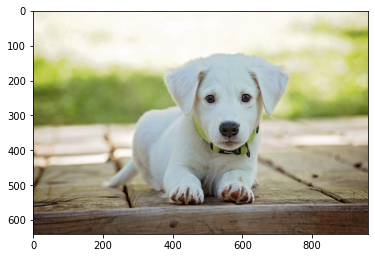

In [6]:
plt.figure(figsize=(6,6))
plt.imshow(original_image)
plt.show()

## Format Image

We will now resize and normalize our image so that is compatible with the module we are going to use. In this notebook we will use the [MobileNet](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4) model which was trained in ImageNet. For this module, the input images are expected to have color values in the range `[0,1]` and to have an input size of `(224,224)`.

In [0]:
IMAGE_SIZE = (224, 224)
    
img = original_image.resize(IMAGE_SIZE)
img = np.array(img) / 255.0

Let's now plot the reformatted image, to see what it looks like.

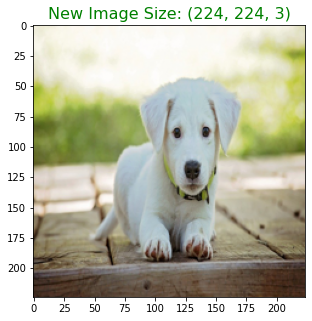

In [8]:
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title('New Image Size: {}'.format(img.shape), fontdict={'size': 16}, color='green')
plt.show()

## Get ImageNet Labels

We will now get the labels for all the 1001 classes in the ImageNet dataset.

In [9]:
!wget -O labels.txt --quiet https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt

with open('labels.txt', 'r') as f:
    labels = [l.strip() for l in f.readlines()]

# get number of labels
num_classes = len(labels)

print('There are a total of {0} labels representing {0} classes.\n'.format(num_classes))

There are a total of 1001 labels representing 1001 classes.



Let's take a look at the first 5 labels. 

In [10]:
for label in labels[0:5]:
    print(label)

background
tench
goldfish
great white shark
tiger shark


## Loading a TensorFlow Hub Module

To load a module, we use its unique **module handle**, which is just a URL string. To obtain the module handle, we have to browse through the catalog of modules in the [TensorFlow Hub](https://tfhub.dev/) website. 

For example, in this case, we will be using the complete **MobileNet** model. If we go to [MobileNet's webpage](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4) in the TensorFlow Hub website, we will see that the module handle for this module is:

```
'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
```

Finally, we'll make use of TensorFlow Hub's, `load` API to load the module into memory. 

In [0]:
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
module = hub.load(MODULE_HANDLE)

## Performing Inference

Once we have loaded the module, we can then start running inference on it. Note however, that the module generates the final layer's logits without any activations. Therefore, we have to apply the `softmax` activation to the module's output. The result will be a Tensor of shape `(1, 1001)`, where the first dimension refers to the batch size. In this case it is just `1` because we only passed 1 image. 

In the cell below, we will pass the image of the puppy and get the top 5 predictions from our model along with their probability scores.

In [12]:
predictions = tf.nn.softmax(module([img]))[0]

top_k_pred_values, top_k_indices = tf.math.top_k(predictions, k=5)

top_k_pred_values = top_k_pred_values.numpy()
top_k_indices = top_k_indices.numpy()

for value, i in zip(top_k_pred_values, top_k_indices):
    print('{}: {:.3}'.format(labels[i], value))

Labrador retriever: 0.422
Great Pyrenees: 0.0658
kuvasz: 0.0619
tennis ball: 0.0484
Old English sheepdog: 0.0289


## Using a TensorFlow Hub Module with Keras

We can also integrate TensorFlow Hub modules into the high level Keras API. In this case, we make use of the `hub.KerasLayer` API to load it. We can add the `hub.KerasLayer` to a Keras `sequential` model along with an activation layer. Once the model is built, all the Keras model methods can be accessed like you would normally do in Keras.

In [0]:
model = tf.keras.Sequential([
        hub.KerasLayer(MODULE_HANDLE,
                       input_shape=IMAGE_SIZE + (3,)),
        tf.keras.layers.Activation('softmax')
])

## Performing Inference

To perform inference with the Keras model, we have to add a dimension to our image to account for the batch size. Remember that our Keras model expects the input to have shape `(batch_size, image_size)`, where the `image_size` includes the number of color channels.

In [0]:
# Add batch dimension
img_arr = np.expand_dims(img, axis=0)

As we did previously, in the cell below we will pass the image of the puppy and get the top 5 predictions from our Keras model along with their probability scores.

In [15]:
predictions = model.predict(img_arr)[0]
 
top_k_pred_values, top_k_indices = tf.math.top_k(predictions, k=5)

top_k_pred_values = top_k_pred_values.numpy()
top_k_indices = top_k_indices.numpy()

for value, i in zip(top_k_pred_values, top_k_indices):
    print('{}: {:.3}'.format(labels[i], value))

Labrador retriever: 0.422
Great Pyrenees: 0.0658
kuvasz: 0.0619
tennis ball: 0.0484
Old English sheepdog: 0.0289


# Using Feature Vectors with Keras

While we can use complete models as we did in the previous section, perhaps, the most important part of TensorFlow Hub is in how it provides **Feature Vectors** that allows us to take advantage of transfer learning. Feature vectors are just complete modules that had their final classification head removed.

In the cell below we show an example of how a feature vector can be added to a Keras `sequential` model.

In [0]:
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [0]:
# Number of classes in the new dataset
NUM_CLASSES = 20

model = tf.keras.Sequential([
        hub.KerasLayer(MODULE_HANDLE,
                       input_shape=IMAGE_SIZE + (3,)),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

Now that the model is built, the next step in transfer learning will be to train the model on a new dataset with the new classifier (i.e. the last layer of the model). Remember that the number of output units in the last layer will correspond to the number of classes in your new dataset. After the model has been trained, we can perform inference in the same way as with any Keras model (see previous section).

# Saving a TensorFlow Hub Module for Local Use

We can download TensorFlow Hub modules, by explicitly downloading the module as a **SavedModel** archived as a tarball. This is useful if we want to work with the module offline.

To do this, we first have to download the Hub module by appending a query parameter to the module handled URL string. This is done by setting the TF Hub format query parameter as shown below. For now, only the compressed option is defined.

In [18]:
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4?tf-hub-format=compressed'
!wget -O ./saved_model.tar.gz $MODULE_HANDLE

--2020-05-12 08:14:25--  https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4?tf-hub-format=compressed
Resolving tfhub.dev (tfhub.dev)... 64.233.166.113, 64.233.166.139, 64.233.166.102, ...
Connecting to tfhub.dev (tfhub.dev)|64.233.166.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/tfhub-modules/google/tf2-preview/mobilenet_v2/classification/4.tar.gz [following]
--2020-05-12 08:14:25--  https://storage.googleapis.com/tfhub-modules/google/tf2-preview/mobilenet_v2/classification/4.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 2a00:1450:400c:c0c::80
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13256595 (13M) [application/x-tar]
Saving to: ‘./saved_model.tar.gz’

./saved_model.tar.g 100%[===================>]  12.64M  --.-KB/s    in 0.05s   

2020-05-12 08:14:25 (262 MB/s

Next, we need to decompress the tarball.

In [19]:
# Untar the tarball
!mkdir -p ./saved_model
!tar xvzf ./saved_model.tar.gz -C ./saved_model

./
./assets/
./saved_model.pb
./variables/
./variables/variables.index
./variables/variables.data-00000-of-00001


# Running a TensorFlow Hub Module Locally

We can load the SavedModel containing the saved TensorFlow Hub module by using `hub.load`.

In [0]:
module = hub.load('./saved_model')

After the TensorFlow Hub module is loaded, we can start making inferences as shown below. As before, we will pass the image of the puppy and get the top 5 predictions from our model along with their probability scores.

In [21]:
predictions = tf.nn.softmax(module([img]))[0]

top_k_pred_values, top_k_indices = tf.math.top_k(predictions, k=5)

top_k_pred_values = top_k_pred_values.numpy()
top_k_indices = top_k_indices.numpy()

for value, i in zip(top_k_pred_values, top_k_indices):
    print('{}: {:.3}'.format(labels[i], value))

Labrador retriever: 0.422
Great Pyrenees: 0.0658
kuvasz: 0.0619
tennis ball: 0.0484
Old English sheepdog: 0.0289


## Changing the Download Location of TensorFlow Hub Modules. 

Finally, we can change the download location of TensorFlow Hub modules to a more permanent location. We can do this by setting the environment variable `'TFHUB_CACHE_DIR'` to the directory we want our modules to be saved in. 

In Python, we can set this environment variable in the environment dictionary that's present in the Pythons `os` module as you can see below. 

In [0]:
new_dir = './hub_cache_dir'

os.environ['TFHUB_CACHE_DIR'] = new_dir

Once we set the new location of the TF Hub cache directory environment variable, all the subsequent modules that we request will get downloaded to that location. 

In [0]:
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
module = hub.load(MODULE_HANDLE)

We can take a look the contents of the new directory and all its subdirectories by using the `-R` option.

In [24]:
!ls -R {new_dir}

./hub_cache_dir:
426589ad685896ab7954855255a52db3442cb38d
426589ad685896ab7954855255a52db3442cb38d.descriptor.txt

./hub_cache_dir/426589ad685896ab7954855255a52db3442cb38d:
assets	saved_model.pb	variables

./hub_cache_dir/426589ad685896ab7954855255a52db3442cb38d/assets:

./hub_cache_dir/426589ad685896ab7954855255a52db3442cb38d/variables:
variables.data-00000-of-00001  variables.index
